In [1]:
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model,load_model
from keras.preprocessing.image import img_to_array
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import glob
import random

### Data Preprocessing

In [2]:
dataset = "lgg-mri-segmentation/kaggle_3m/"
img_height = 128
img_width = 128
img_channels = 3

In [3]:
data_map = []
for sub_dir_path in glob.glob(dataset+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: lgg-mri-segmentation/kaggle_3m\data.csv
This is not a dir: lgg-mri-segmentation/kaggle_3m\README.md


,dirname,path
0,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
1,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
2,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
3,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
4,kaggle_3m\TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...


In [4]:
df_imgs = df[~df['path'].str.contains("mask")]
masks=[]
for i in df_imgs['path']:
    a=str(i).split(".")
    a=a[0]+'_mask.tif'
    masks.append(a)
images = df_imgs['path'].tolist()

In [5]:
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": images,
                   "mask_path": masks})
print(df.image_path[1])
print(df.mask_path[1])

lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif
lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif


In [6]:
x_train = np.zeros((len(df.image_path),128,128,3),dtype=np.uint8)
y_train = np.zeros((len(df.mask_path),128,128,1),dtype=np.bool)
print("X shape",x_train.shape)
print("Y shape",y_train.shape)

X shape (3929, 128, 128, 3)
Y shape (3929, 128, 128, 1)


In [7]:
for n,id_ in tqdm(enumerate(df.image_path),total=len(df.image_path)):
    img = cv2.imread(id_)
    img = cv2.resize(img,(img_height,img_width))
    x_train[n] = img

100%|█████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:21<00:00, 186.56it/s]


In [8]:
for n,mask_file in tqdm(enumerate(df.mask_path), total = len(df.mask_path)):
    mask = cv2.imread(mask_file,0)
    mask = np.expand_dims(cv2.resize(mask,(img_height,img_width)),axis=-1)
    y_train[n] = mask

100%|█████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:16<00:00, 240.03it/s]


### Data Visualization

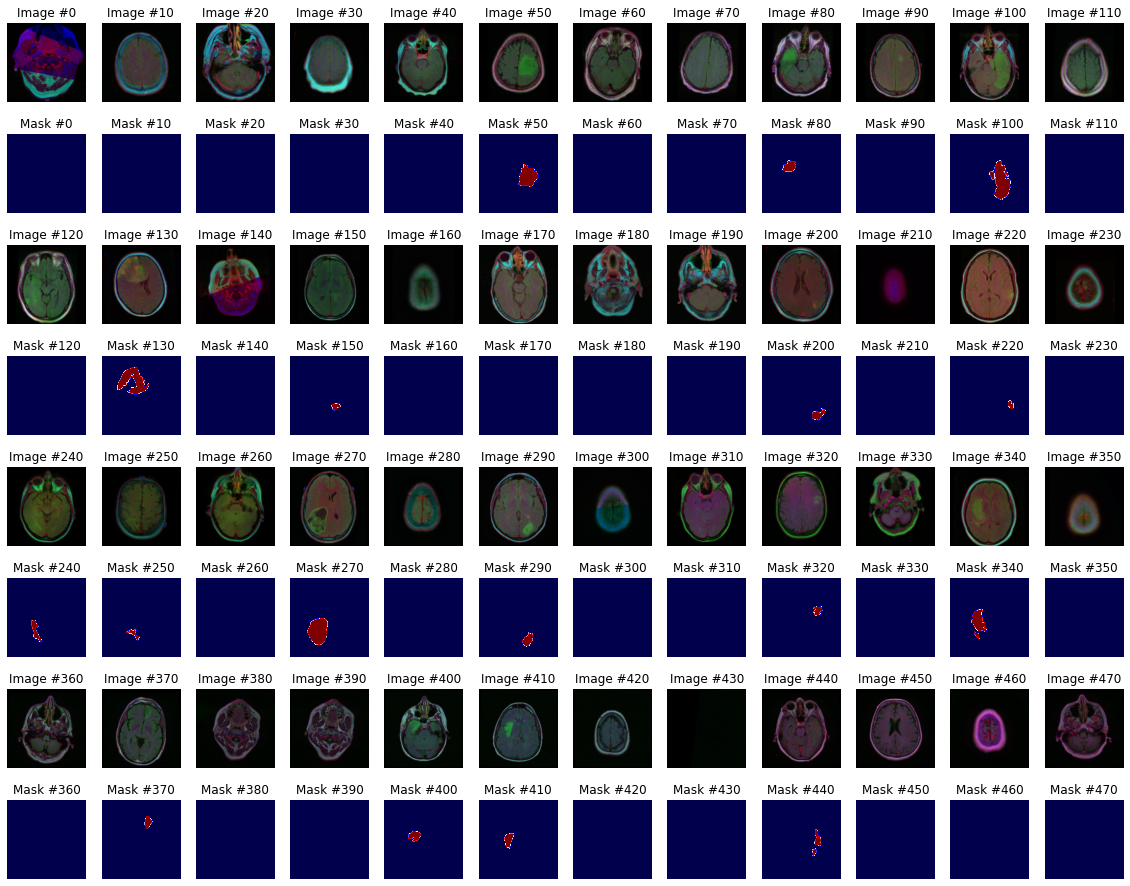

In [9]:
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(x_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(y_train[pos],cmap='seismic')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Creating Model

In [36]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                     
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)])
    return model

In [37]:
input_shape = (128,128,3)
model = build_vgg16_unet(input_shape)
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
________________________________________________________________________________________

### Training

In [ ]:
modelcheckpoint = ModelCheckpoint('unets_today.pb',monitor='val_loss',verbose=1,mode='min',save_best_only=True)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5,verbose = 1,restore_best_weights = True)
results = model.fit(x_train, y_train, validation_split=0.1,
                    batch_size=16, epochs=5, 
                    callbacks=[earlystop, modelcheckpoint])

### Predicting

In [14]:
modelp = load_model('brain3.h5')
preds_train = modelp.predict(x_train, verbose=1)

123/123 [==============================] - 344s 3s/step


In [34]:
def predict_mask(img):
    img = cv2.imread(img)
    img = cv2.resize(img,(128,128))
    plt.imshow(img)
    img1 = img_to_array(img)
    img1 = np.expand_dims(img1,axis=0)
    pred = modelp.predict(img1)
    image=(pred[0]*255).astype(np.uint8)
    edged = cv2.Canny(image, 30, 200)
    contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(cv2.polylines(img.copy(),contours,True,(255,254,0)))

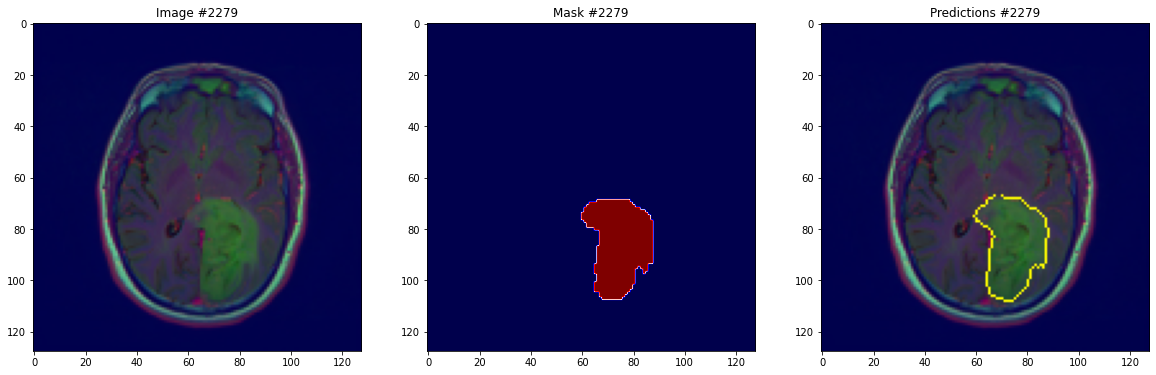

In [48]:
# Ploting our predicted masks
ix = random.randint(0, len(x_train))
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
plt.imshow(x_train[ix])
plt.title("Image #{}".format(ix))

# Our original training mask
plt.subplot(132)
plt.imshow(np.squeeze(y_train[ix]),cmap='seismic')
plt.title("Mask #{}".format(ix))

# Prediction on training images
plt.subplot(133)
image=(preds_train[ix]*255).astype(np.uint8)
edged = cv2.Canny(image, 30, 200)
contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.polylines(x_train[ix].copy(),contours,False,(255,254,0)))
plt.title("Predictions #{}".format(ix))
plt.show()


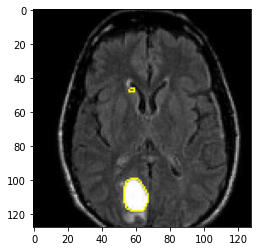

In [35]:
predict_mask("MRI-Brain-Images-abenign-bmalignant-images_Q320.jpg")